# Midplane Section Analysis
Code to analyze the result of `midplane_section.py`

## Imports

In [1]:
# %% Imports
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.integrate
import scipy.interpolate

## Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

import pyvista as pv

from tqdm import tqdm

import pickle

## Utility libraries
from netCDF4 import Dataset
import glob

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, GaussHermiteFunction
from c1lgkt.fields.field_interpolators import compute_balloon_interpolation
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

In [2]:
# %% Load files and perform setup

eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')

xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, **geom_files)

uph = np.load('./outputs/phase_vel.npz')['u_lstsq']

# Set up zonal interpolation function
tind = 400
ksurf0 = 196
zpot = xgcdata['pot00'][tind,:]
zpot_psi = xgcdata['psi00'][:]
interp_zpot = scipy.interpolate.CubicSpline(zpot_psi, zpot, extrapolate=True)
zonalFields = XgcZonalFieldHandler(eq, xgcdata, tind)

# Set up ballooning mode interpolator
fit_results = np.load('./outputs/fit_results.npz', allow_pickle=True)
params_g, params_gh = fit_results['params_g'], fit_results['params_gh']

# Set up the interpolator
mode = GaussHermiteFunction(params_g[:4], params_gh)
interp_balloon = [(39, mode)]

ballFields = GaussHermiteFieldHandler(geom, interp_zpot, interp_balloon)

tind0 = tind #424, 386

omega_frame = -uph[tind0,ksurf0]*geom.q_surf[ksurf0]*1e-3
rotating_frame = particle_motion.RotatingFrameInfo(0, omega_frame, tind0)
t0 = rotating_frame.t0

In [10]:
# %% Load data and compute Poincare sections

filelabel = 'midplane_blob_deut_trapped_r100'
output_dir = 'D:/Documents/IFS/hmode_jet/outputs/'

paths = glob.glob(output_dir+'sections/{}/[0-9][0-9][0-9][0-9][0-9].npz'.format(filelabel))

num_saves = len(paths)
print('num_saves: {}'.format(num_saves))
ncheckpoint = 800

t = np.empty(num_saves*ncheckpoint)
y = None
dy = None

# TODO: Refactor so we don't load the entire trajectory into memory to compute the punctures
for kc in range(num_saves):
    with np.load(output_dir + 'sections/{}/{:05d}.npz'.format(filelabel, kc)) as data:
        t[kc*ncheckpoint:(kc+1)*ncheckpoint] = data['t']
        if kc == 0:
            y = np.empty((data['y'].shape[0], len(t)))
            dy = np.empty((data['y'].shape[0], len(t)))
            
        y[:,kc*ncheckpoint:(kc+1)*ncheckpoint] = data['y']
        dy[:,kc*ncheckpoint:(kc+1)*ncheckpoint] = data['dy']

nump = y.shape[0]//5

# Compute Poincare section
ppunc, npunc = particle_tools.compute_midplane_punctures(t, y, geom)
ppunc2, npunc2 = particle_tools.compute_toroidal_punctures(t, y, rotating_frame, period=(2*np.pi/39), offset = (-np.pi/39))

y = None
dy = None


num_saves: 100


## Analysis

In [75]:
# %% Compute rotation numbers and other quantities
pp = particle_motion.deut
ravgs = np.empty(nump)
iota = np.empty(nump)
bounce_time = np.empty(nump)
lphiavgs = np.empty(nump)

for k in range(0,nump,2):

    ## Compute the rotation number
    varphi = np.unwrap(ppunc[k][1][1,:] - omega_frame * (ppunc[k][0] - t0))
    # Discrete time s
    s = np.linspace(0,1, len(varphi)-1, endpoint=False)
    # weight function
    w = np.zeros(len(varphi)-1)
    w[1:] = np.exp(-1.0 / (s[1:] * (1-s[1:])))
    iota[k] = np.sum(np.diff(varphi) * w) / (2*np.pi*np.sum(w))

    ## Compute angular momentum
    r = ppunc[k][1][0,:]
    varphi = np.unwrap(ppunc[k][1][1,:] - omega_frame * (ppunc[k][0] - t0))
    z = ppunc[k][1][2,:]
    vll = ppunc[k][1][3,:]

    psi = eq.interp_psi.ev(r, z)

    # Toroidal angular momentum
    bv = eq.compute_bv(r, z)
    modb = np.linalg.norm(bv, axis=0)
    lphi = psi + pp.m * vll * r * bv[1,:] / modb / pp.z

    lphiavgs[k] = np.sum(0.5*(lphi[1:] + lphi[:-1]) * w) / np.sum(w)

    ## Compute the average r
    rmid = (ppunc[k][1][0,1:] + ppunc[k][1][0,:-1])/2.0
    ravgs[k] = np.sum(rmid * w) / np.sum(w)

    ## Compute the bounce time
    bounce_time[k] = np.sum(np.diff(ppunc[k][0]) * w) / np.sum(w)

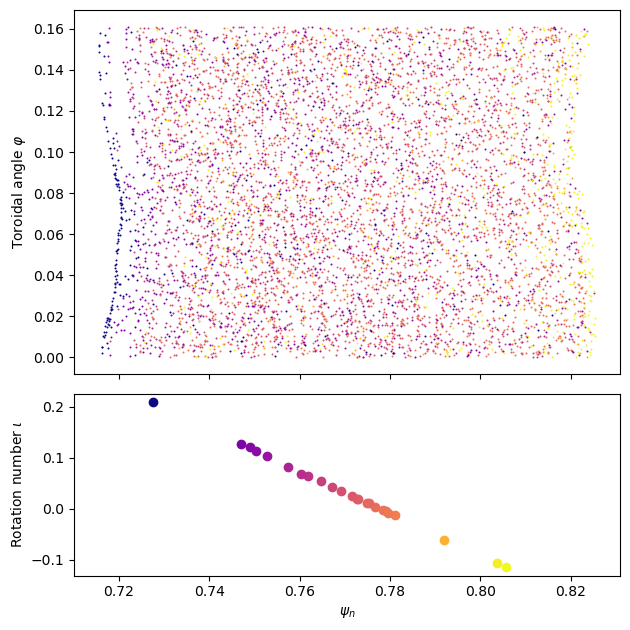

In [76]:
# %% Plot the outer midplane section

fig, axs = plt.subplots(2,1, sharex=True, figsize=(6.4,6.4), height_ratios=(2,1))

rmax = np.max(lphiavgs[::2])
rmin = np.min(lphiavgs[::2])
iota_argmin = np.argmin(iota[::2])
r_shearless = ravgs[::2][iota_argmin]

for k in range(0,nump,2):
    ntor = 39
    psiavg = eq.interp_psi.ev(ravgs[k], eq.zaxis)
    
    ## Compute color to plot based on the radial location
    norm = mpl.colors.Normalize(vmin=rmin, vmax=rmax)
    color = mpl.cm.plasma(norm(lphiavgs[k]))
    #color = mpl.cm.PiYG(np.sign(psiavg/eq.psix - 0.8))

    ## Compute coordinates to plot at
    r = ppunc[k][1][0,:]
    varphi = np.unwrap(ppunc[k][1][1,:] - omega_frame * (ppunc[k][0] - t0))
    z = ppunc[k][1][2,:]
    vll = ppunc[k][1][3,:]

    psi = eq.interp_psi.ev(r, z)

    # Toroidal angular momentum
    bv = eq.compute_bv(r, z)
    modb = np.linalg.norm(bv, axis=0)
    lphi = psi + pp.m * vll * r * bv[1,:] / modb / pp.z

    ## Plot the Poincare section, colored by trajectory
    axs[0].scatter(lphi/eq.psix, np.mod(varphi,2*np.pi/ntor), s=4*(72/100.0)**2, lw=0, color=color, rasterized=True)

    

    ## Plot the rotation number
    axs[1].scatter(lphiavgs[k]/eq.psix, iota[k], color=color)


#plt.suptitle('Trapped electron Poincare section')

axs[0].set_ylabel(R'Toroidal angle $\varphi$')
#axs[0].set_ylabel(R'Major radius $R$')
axs[1].set_xlabel(R'$\psi_n$')
axs[1].set_ylabel(R'Rotation number $\iota$')

plt.tight_layout()

#plt.savefig('./outputs/{}_toroidal.pdf'.format(filelabel), dpi=300, bbox_inches='tight')

(<matplotlib.patches.Rectangle at 0x193c6077e60>,
 (<matplotlib.patches.ConnectionPatch at 0x193cdfadc70>,
  <matplotlib.patches.ConnectionPatch at 0x193ce1a8e30>))

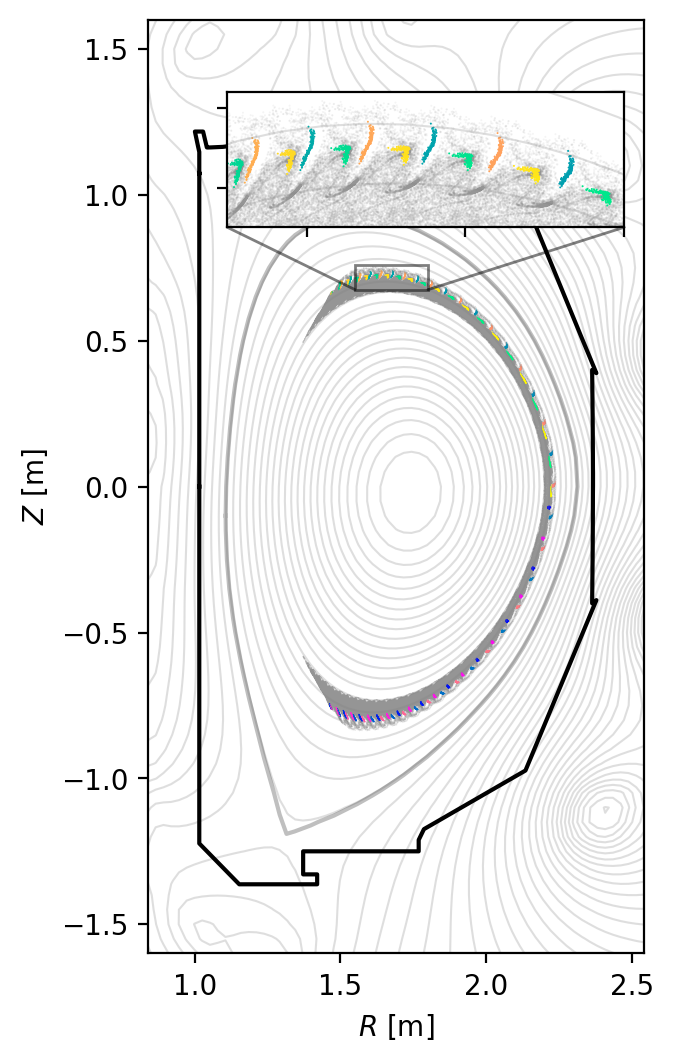

In [ ]:
# %% Plot the poloidal cross-section section in (R,Z)
fig, ax = plt.subplots(1,1, figsize=(3.2,6.4), dpi=200)
#fig, axs = plt.subplots(1,2)

# Create inset axes for zoomed in view
axins = ax.inset_axes([0.16, 0.77, 0.8, 0.16], xticklabels=[], yticklabels=[]) # [left, bottom, width, height]
#axins = ax.inset_axes([0.21, 0.01, 0.8, 0.22], xticklabels=[], yticklabels=[]) # [left, bottom, width, height]

eq.plot_magnetic_geometry(ax, alpha=0.25)
eq.plot_magnetic_geometry(axins, alpha=0.25)

# Set maxpunc based on whether we're plotting trapped particles or not
if 'trapped' in filelabel:
    maxpunc = 40
else:
    maxpunc = 80

for k in range(0,nump):
    # Choose color based on whether or not we're plotting the blob or the normal Poincare section
    if 'blob' in filelabel:
        # Plot gray points beyond the maximum puncture
        color = mpl.cm.Greys(0.5*np.ones(shape=(len(ppunc2[k][0]),)))

        ax.scatter(ppunc2[k][1][0,maxpunc:], ppunc2[k][1][2,maxpunc:], s=0.25*(72/100.0)**2, lw=0, color=color[maxpunc:,:], rasterized=True, alpha=0.1)
        axins.scatter(ppunc2[k][1][0,maxpunc:], ppunc2[k][1][2,maxpunc:], s=1.0*(72/100.0)**2, lw=0, color=color[maxpunc:,:], rasterized=True, alpha=0.1)
    else:
        # Color based on the radial location
        norm = mpl.colors.Normalize(vmin=rmin, vmax=rmax)
        color = mpl.cm.plasma(norm(lphiavgs[k]))

        ax.scatter(ppunc2[k][1][0,::1], ppunc2[k][1][2,::1], s=0.25*(72/100.0)**2, lw=0, color=color[::1,:], rasterized=True, alpha=0.2)
        axins.scatter(ppunc2[k][1][0,::1], ppunc2[k][1][2,::1], s=1.0*(72/100.0)**2, lw=0, color=color[::1,:], rasterized=True, alpha=0.2)

# When we're plotting the blob, plot the initial punctures afterwards so the z-ordering is correct
if 'blob' in filelabel:
    for k in range(0,nump):
        
        if 'trapped' in filelabel:
            # If we're trapped, we need to plot all punctures, so we need to collect them
            # all together to plot them
            npuncmax = np.argmax(npunc2[k][0] > ppunc2[k][0][maxpunc])

            # Combined time of punctures
            tpunc2 = np.concatenate((npunc2[k][0][:npuncmax], ppunc2[k][0][:maxpunc]))
            # Combined coordinates of punctures
            apunc2 = np.concatenate((npunc2[k][1][:,:npuncmax], ppunc2[k][1][:,:maxpunc]), axis=1)
            # Label whether we're co-passing or counter-passing
            spunc2 = np.concatenate((-np.ones(npuncmax), np.ones(maxpunc)))

            # Sort the punctures by time
            psort = np.argsort(tpunc2)
            tpunc2 = tpunc2[psort]
            apunc2 = apunc2[:,psort]
            spunc2 = spunc2[psort]

            # Color based on the time of the puncture
            color = mpl.cm.winter(tpunc2 / tpunc2[-1])
            color2 = mpl.cm.spring(tpunc2 / tpunc2[-1])
            color[1::2,:] = color2[1::2,:]

            #color[spunc2 < 0,3] = 0.05

            ax.scatter(apunc2[0,:], apunc2[2,:], s=0.25*(72/100.0)**2, lw=0, color=color, rasterized=True)
            axins.scatter(apunc2[0,:], apunc2[2,:], s=1.0*(72/100.0)**2, lw=0, color=color, rasterized=True)
        else:
            # Color based on the time of the puncture
            color = mpl.cm.winter(ppunc2[k][0][:] / ppunc2[k][0][maxpunc])
            color2 = mpl.cm.spring(ppunc2[k][0][:] / ppunc2[k][0][maxpunc])
            color[1::2,:] = color2[1::2,:]

            ax.scatter(ppunc2[k][1][0,:maxpunc], ppunc2[k][1][2,:maxpunc], s=0.25*(72/100.0)**2, lw=0, color=color[:maxpunc,:], rasterized=True)
            axins.scatter(ppunc2[k][1][0,:maxpunc], ppunc2[k][1][2,:maxpunc], s=1.0*(72/100.0)**2, lw=0, color=color[:maxpunc,:], rasterized=True)
    

axins.set_xlim(1.55, 1.8)
#axins.set_ylim(-0.82, -0.735)
axins.set_ylim(0.675, 0.76)
ax.set_xlabel(R'$R$ [m]')
ax.set_ylabel(R'$Z$ [m]')

ax.indicate_inset_zoom(axins, edgecolor="black")

#axs[0].set_title(R'$v_{\parallel} \hat{\mathbf{b}}\cdot\hat{\boldsymbol{\varphi}}$ > 0')
#axs[1].set_title(R'$v_{\parallel} \hat{\mathbf{b}}\cdot\hat{\boldsymbol{\varphi}}$ < 0')

plt.savefig('./outputs/{}_poloidal.pdf'.format(filelabel), dpi=300, bbox_inches='tight')

In [ ]:
# %% Save data necessary for plotting

section_data = {
    'ravgs': ravgs,
    'iota': iota,
    'bounce_time': bounce_time,
    'ppunc': ppunc,
    'npunc': npunc,
    'ppunc2': ppunc2,
    'npunc2': npunc2,
    't0': t0,
    'omega_frame': omega_frame,
    'tind0': tind0
}

with open('./outputs/sections/{}.pkl'.format(filelabel), 'wb') as f:
    pickle.dump(section_data, f)

104.56427438271832
-102.86321103975456


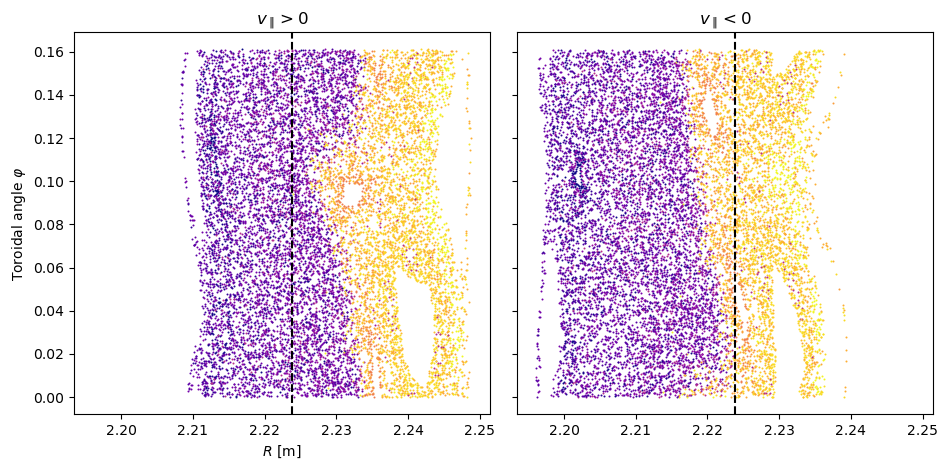

In [ ]:
# %% Plot symmetry breaking in outer midplane section

fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(9.6,4.8))

rmax = np.max(ravgs)
rmin = np.min(ravgs)

rsurf = eq.interp_router(geom.psi_surf[ksurf0]/eq.psix)

for k in range(nump):
    ntor = 39
    
    ## Compute color to plot based on the radial location
    norm = mpl.colors.Normalize(vmin=rmin, vmax=rmax)
    color = mpl.cm.plasma(norm(ravgs[k]))

    r = ppunc[k][1][0,:]
    varphi = np.unwrap(ppunc[k][1][1,:] - omega_frame * (ppunc[k][0] - t0))

    rn = npunc[k][1][0,:]
    varphin = np.unwrap(npunc[k][1][1,:] - omega_frame * (npunc[k][0] - t0))

    ## Plot the Poincare section, colored by trajectory
    axs[0].scatter(r, np.mod(varphi,2*np.pi/ntor), s=4*(72/100.0)**2, lw=0, color=color, rasterized=True)
    axs[1].scatter(rn, np.mod(varphin,2*np.pi/ntor), s=4*(72/100.0)**2, lw=0, color=color, rasterized=True)

print(np.average(ppunc[k][1][3,:]))
print(np.average(npunc[k][1][3,:]))
#plt.suptitle('Trapped electron Poincare section')

axs[0].axvline(rsurf, color='k', ls='--')
axs[1].axvline(rsurf, color='k', ls='--')

axs[0].set_ylabel(R'Toroidal angle $\varphi$')
#axs[0].set_ylabel(R'Major radius $R$')
axs[0].set_xlabel(R'$R$ [m]')
#axs[0].set_ylabel(R'Rotation number $\iota$')

axs[0].set_title(R'$v_{\parallel} > 0$ (co-current)')
axs[1].set_title(R'$v_{\parallel} < 0$ (ctr-current)')

plt.tight_layout()

plt.savefig('./outputs/{}_toroidal_both.pdf'.format(filelabel), dpi=300, bbox_inches='tight')

In [ ]:
# %% Plot poloidal cross-section in (Z,v_||)

plt.figure()

fig, axs = plt.subplots(2,1)

rotation_number = np.empty(nump)

for k in range(0,nump):
    # Sort the combined punctures by their puncture time
    tpunc = np.concatenate((ppunc2[k][0], npunc2[k][0]))
    tsort = np.argsort(tpunc)
    tpunc = tpunc[tsort]
    print(np.average(np.diff(tpunc)))

    # Unpack and collect together the positive and negative punctures
    r = np.concatenate((ppunc2[k][1][0,:], npunc2[k][1][0,:]))[tsort]
    z = np.concatenate((ppunc2[k][1][2,:], npunc2[k][1][2,:]))[tsort]
    vll = np.concatenate((ppunc2[k][1][3,:], npunc2[k][1][3,:]))[tsort]

    # Compute theta
    psi = eq.interp_psi.ev(r, z)
    gtheta = np.arctan2(z-eq.zaxis, r-eq.raxis)
    dtheta = geom.interp_gdtheta_grid(psi, gtheta)
    theta = gtheta + dtheta

    ## Compute rotation numbers using weighted birkhoff average

    # Compute winding theta around the origin in (theta, vll) space
    winding = np.unwrap(np.arctan2(theta, vll))
    
    # discrete time s
    s = np.arange(len(theta)-1) / (len(theta)-1)
    # weight function
    w = np.zeros(len(theta)-1)
    w[1:] = np.exp(-1.0 / (s[1:] * (1-s[1:])))
    # WBA formula for rotation number
    rotation_number[k] = np.sum(w * np.diff(winding)) / np.sum(w)

    # Compute average area enclosed by the trajectory
    area = np.sum((np.diff(theta) * (vll[:-1] + vll[1:]) / 2.0) * w) / rotation_number[k]

    # Plot, colored by rotation number
    bounds = (0.07214376658924238, 0.08324086979945851)
    norm = mpl.colors.Normalize(vmin=bounds[0], vmax=bounds[1])
    color = mpl.cm.plasma(norm(rotation_number[k]))

    axs[0].scatter(theta, vll, s=4*(72/100.0)**2, lw=0, color=color)
    if np.abs(rotation_number[k]) > 0.01:
        axs[1].scatter(area, rotation_number[k], color=color)

print((np.min(rotation_number), np.max(rotation_number)))


0.005867482787194623
0.006088601543336555
0.0058785649915219
0.0060993560135515264
0.006012407714508888
0.0061330884573050195
0.005610253848820004
0.006246916912522602
0.005735148175148647
0.006383095721881616
0.00611952977029218
0.006406956380704322
0.006133933737228225
0.006265944806902099
0.005886577831411924
0.006132623411415823
(0.07206973881053441, 0.08323632719108245)


In [ ]:

# %% Poloidal cross-section flux coordinates (psi, theta)


fig, axs = plt.subplots(2,1,sharex='all')

ravgs = np.empty(nump)

maxrot = -np.inf
minrot = np.inf

for k in range(nump):
    #ravgs[k] = np.average(np.concatenate((ppunc[k][1][0,:], npunc[k][1][0,:])))

    
    #cplot = 'tab:blue'

    thetap = geom.compute_theta(ppunc2[k][1][0,:], ppunc2[k][1][2,:])
    psip = eq.interp_psi.ev(ppunc2[k][1][0,:], ppunc2[k][1][2,:])
    thetan = geom.compute_theta(npunc2[k][1][0,:], npunc2[k][1][2,:])
    psin = eq.interp_psi.ev(npunc2[k][1][0,:], npunc2[k][1][2,:])

    #axs[0].scatter(thetap, ppunc2[k][1][3,:], s=1*(72/100.0)**2, lw=0)
    #axs[1].scatter(thetan, npunc2[k][1][3,:], s=1*(72/100.0)**2, lw=0)

    #cplotp = 'tab:blue' if np.average(psip) > geom.psi_surf[200] else 'tab:orange'
    #cplotn = 'tab:blue' if np.average(psin) > geom.psi_surf[200] else 'tab:orange'

    # eq.interp_router(psip/eq.psix)

    if k%2 == 1:
        axs[0].scatter(thetap, psip, s=4*(72/100.0)**2, lw=0)
    else:
        axs[1].scatter(thetan, psin, s=4*(72/100.0)**2, lw=0)

axs[1].set_xlabel(R'Poloidal angle $\theta$')
axs[0].set_ylabel(R'Mapped outboard midplane $R$')

plt.suptitle(R'Passing ion Poincare section')

In [ ]:
# %% Check bounce times and poloidal transit times
plt.figure()
plt.scatter(ravgs, bounce_time, marker='.', c='tab:orange')
print(bounce_time)

[0.48498742 0.48449365 0.48475963 0.48446286 0.48467071 0.4841977
 0.48845671 0.48351919 0.48576335 0.48362654 0.48445724 0.48364858
 0.48418176 0.4833157  0.48499821 0.48390607]



## Diagnostic Plots

Text(0, 0.5, 'Z')

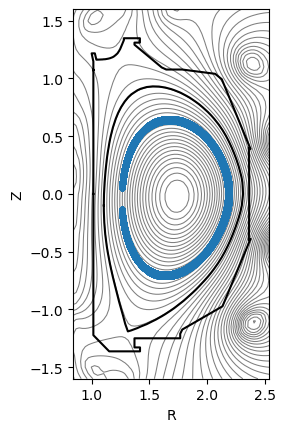

In [ ]:
# %% Plot trajectories in the (R,Z) plane atop the ballooning mode

plt.figure()

ax = plt.subplot(111)

eq.plot_magnetic_geometry(ax)
for k in [0]:
    ax.plot(y[k + 0*nump,:], y[k + 2*nump,:], marker='.')

rplot, zplot = np.linspace(2.15, 2.26, 256), np.linspace(-0.2, 0.2, 1024)
rgrid, zgrid = np.meshgrid(rplot, zplot)
varphigrid = np.zeros(rgrid.shape)

rflat, zflat, varphiflat = rgrid.flatten(), zgrid.flatten(), varphigrid.flatten()

psi_ev, ff_ev = eq.compute_psi_and_ff(rflat, zflat)

phi = compute_balloon_interpolation(
    0.0, rflat, zflat, varphiflat, psi_ev, eq, geom, [interp_balloon], gradient=False)

phigrid = phi.reshape(rgrid.shape)

#plt.pcolormesh(rplot, zplot, phigrid, cmap='viridis')

plt.xlabel('R')
plt.ylabel('Z')

In [ ]:
# %% Plot trajectories in phi, theta plane

def centerize(z):
    return np.mod(z+np.pi,2*np.pi)-np.pi

plt.figure()

k = 1

theta = geom.compute_theta(y[k + 0*nump], y[k + 2*nump])
psi = eq.interp_psi.ev(y[k + 0*nump], y[k + 2*nump])
#plt.scatter(np.mod(y[k + 1*nump],2*np.pi), centerize(theta), c=psi, s=9*(72/100.0)**2)

plt.scatter(psi / eq.psix, theta, s=4*(72/100.0)**2, lw=0, c=t)

plt.xlabel('psi_n')
plt.ylabel('theta')

In [ ]:
# %% Plot trajectories vs. time

k = 0

plt.figure()
plt.plot(t, dy[k + 0*nump], marker='.')
#plt.twinx()
plt.plot(t, dy[k + 2*nump], marker='.', c='tab:orange')